In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
data1=pd.read_csv('../input/train_LZdllcl.csv')
data1.head()

,employee_id,department,region,education,gender,recruitment_channel,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met >80%,awards_won?,avg_training_score,is_promoted
0,65438,Sales & Marketing,region_7,Master's & above,f,sourcing,1,35,5.0,8,1,0,49,0
1,65141,Operations,region_22,Bachelor's,m,other,1,30,5.0,4,0,0,60,0
2,7513,Sales & Marketing,region_19,Bachelor's,m,sourcing,1,34,3.0,7,0,0,50,0
3,2542,Sales & Marketing,region_23,Bachelor's,m,other,2,39,1.0,10,0,0,50,0
4,48945,Technology,region_26,Bachelor's,m,other,1,45,3.0,2,0,0,73,0


In [2]:
data1.dtypes
#There are continuous variable and categorical variable. 
#We will first start with numerical variable.

employee_id               int64
department               object
region                   object
education                object
gender                   object
recruitment_channel      object
no_of_trainings           int64
age                       int64
previous_year_rating    float64
length_of_service         int64
KPIs_met >80%             int64
awards_won?               int64
avg_training_score        int64
is_promoted               int64
dtype: object

There are broadly two variable categories-
 - Categorical Varaibles
 - Numerical/Continuous Variables

There are two major classes of categorical data- Nominal and Ordinal

**Nominal**- in this there is no concept of order. e.g. racial types- Asian, American, Europians, etc. There is no order here.
**Ordinal**- we have some sense order amongst the values. e.g. Shoe sizes S, M, L, XL, XXL

**#Handling Ordinal Variables**- Few popular methods
1. Creation of Dummies
2. Mean Encoding

**Dummy creation**- In this we create dummies for the all the unique value that the variable can take. Let's say variable can take m unique values, then we create m-1 dummies.


Let's take column **department**. There are in total 9 unique values. we will create in total 8 dummies. But the problem with this approach if number of unique values that the variable can take is high (high cardinality). It can increases the number columns drastically.

In [3]:
print (len(data1.department.unique()))
dum_department=pd.get_dummies(data1['department'], prefix='department', drop_first=False)
dum_department.head()

9


,department_Analytics,department_Finance,department_HR,department_Legal,department_Operations,department_Procurement,department_R&D,department_Sales & Marketing,department_Technology
0,0,0,0,0,0,0,0,1,0
1,0,0,0,0,1,0,0,0,0
2,0,0,0,0,0,0,0,1,0
3,0,0,0,0,0,0,0,1,0
4,0,0,0,0,0,0,0,0,1


**Mean Encoding**- proportion of positive labels present for a particular value of a categorical variable. Problem with this methodology is overfitting. mean encoding is one of the key transformation applied to categorical variables when we are using Gradient Boosting. Since, in Gradient Boosting tree height is monitored and always restricted to low tree height. As exposing tree to higher tree height leads to overfitting.

In [4]:
data1[['department','is_promoted']].head()


,department,is_promoted
0,Sales & Marketing,0
1,Operations,0
2,Sales & Marketing,0
3,Sales & Marketing,0
4,Technology,0


In [5]:
dpt=pd.DataFrame(data1.department.value_counts())
dpt=dpt.reset_index()
dpt.columns=['department','count']
target_label=data1[['department','is_promoted']].groupby(['department']).sum()
target_label=target_label.reset_index()
final_encoded=pd.merge(dpt,target_label,on='department',how='left')
final_encoded['mean_encoded']=final_encoded['is_promoted']/final_encoded['count']
final_encoded=final_encoded[['department','mean_encoded']]
final_encoded

,department,mean_encoded
0,Sales & Marketing,0.072031
1,Operations,0.090148
2,Procurement,0.096386
3,Technology,0.107593
4,Analytics,0.095665
5,Finance,0.081230
6,HR,0.056245
7,Legal,0.051011
8,R&D,0.069069


In [6]:
data1=pd.merge(data1,final_encoded,on='department',how='left')
data1[['department','mean_encoded']].head()

,department,mean_encoded
0,Sales & Marketing,0.072031
1,Operations,0.090148
2,Sales & Marketing,0.072031
3,Sales & Marketing,0.072031
4,Technology,0.107593


As most of the machine learning algorithms recognise only numbers. Therefore, all non-numeric ordinal variables needs to be transformed into numeric. This can be achieved using a dictionary using Python's map function.

> Before Starting with any modelling, one must first check problem context and try to get as much information possible. For the given dataset we are provided with average training score. But, before we make any comments on this feature's importance we should take a step back and think. How a person would be promoted in a multistate and multi department company-
* Promotion would happen department wise
* Promotion would be region wise
* No. of promotion would be dependent on a particular department. Some departments would be inherently promoting more number of people than other


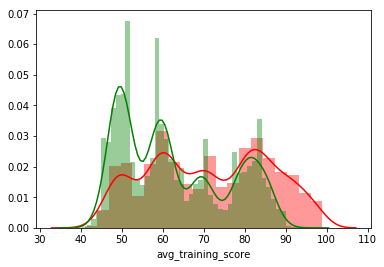

In [7]:
sns.distplot(data1[data1['is_promoted']==1]['avg_training_score'], color='r')
sns.distplot(data1[data1['is_promoted']==0]['avg_training_score'], color='g')
#Observation- Idea behind doing dist plot, plotting separately for categories to identify regions where there are no overlaps. If we can find pockets of
#non-overlap, then the variable can clearly differenitate or classify the target and would add value to the model.

In [8]:
# from sklearn.preprocessing import CategoricalEncoder
data1=pd.merge(data1,data1[['region','department','avg_training_score']].groupby(['region','department']).mean(),how='left',on=['region','department'])
data1=data1.rename(columns={'avg_training_score_x':'avg_training_score','avg_training_score_y':'mean_reg_dpt'})
data1['new_avg_trng_score']=data1['avg_training_score']/data1['mean_reg_dpt']
data1.head()

,employee_id,department,region,education,gender,recruitment_channel,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met >80%,awards_won?,avg_training_score,is_promoted,mean_encoded,mean_reg_dpt,new_avg_trng_score
0,65438,Sales & Marketing,region_7,Master's & above,f,sourcing,1,35,5.0,8,1,0,49,0,0.072031,50.331020,0.973555
1,65141,Operations,region_22,Bachelor's,m,other,1,30,5.0,4,0,0,60,0,0.090148,60.437257,0.992765
2,7513,Sales & Marketing,region_19,Bachelor's,m,sourcing,1,34,3.0,7,0,0,50,0,0.072031,50.133829,0.997331
3,2542,Sales & Marketing,region_23,Bachelor's,m,other,2,39,1.0,10,0,0,50,0,0.072031,50.402667,0.992011
4,48945,Technology,region_26,Bachelor's,m,other,1,45,3.0,2,0,0,73,0,0.107593,80.002597,0.912470


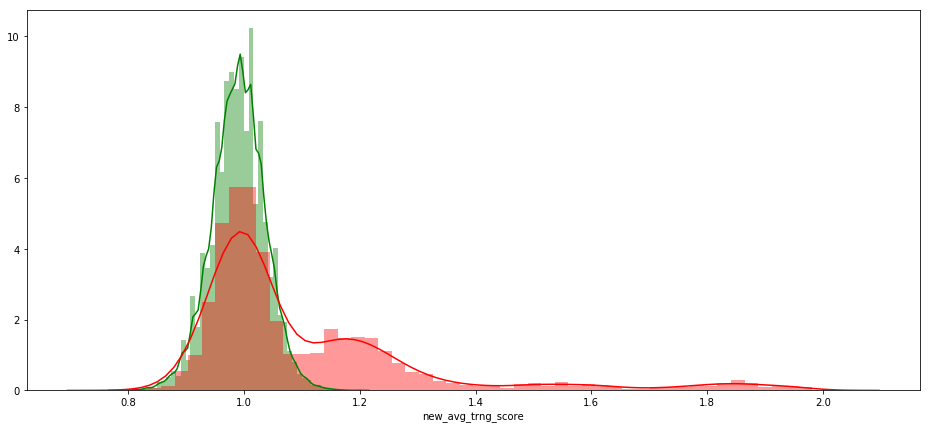

In [9]:
plt.subplots(figsize=(16,7))
sns.distplot(data1[data1.is_promoted==0]['new_avg_trng_score'],color='g',label='Not Promoted')
sns.distplot(data1[data1.is_promoted==1]['new_avg_trng_score'],color='r',label='Promoted')

#as we can see now the engineered feature would be able to classify more accurately, 
#as the regions of non-overlap are more clearly defined

In [10]:
print (data1.age.describe())

count    54808.000000
mean        34.803915
std          7.660169
min         20.000000
25%         29.000000
50%         33.000000
75%         39.000000
max         60.000000
Name: age, dtype: float64


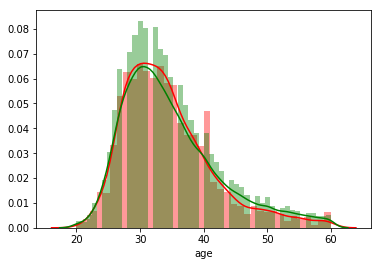

In [11]:
sns.distplot(data1[data1['is_promoted']==1]['age'], color='r')
sns.distplot(data1[data1['is_promoted']==0]['age'], color='g')

**Binning Strategies and handling numeric variables**

Binning is of two types- **Fixed** and **Adaptive**

**Fixed Bining** as the name suggest is fixed- boundries are predefined, which may lead to imperfect bins with with less irregular density in few bins

**Adaptive Binning**- Quantile based binning is a good strategy to use for adaptive binning. Quantiles are specific values or cut-points which help in partitioning the continuous valued distribution of a specific numeric field into  discrete contiguous bins or intervals. Thus, q-Quantiles help in partitioning a numeric attribute into q equal partitions. Popular examples of quantiles include the 2-Quantile known as the median which divides the data distribution into two equal bins, 4-Quantiles known as the quartiles which divide the data into 4 equal bins and 10-Quantiles also known as the deciles which create 10 equal width bins. 

In [12]:
data1['age_bin']=pd.qcut(data1['age'], q=[0,.10,.20,.30,.40,.50,.60,.70,.80,.90,1], labels=False)

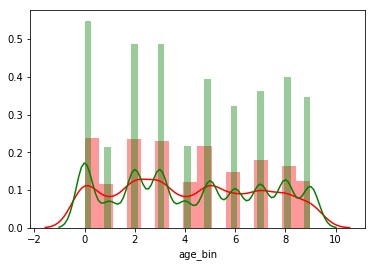

In [13]:
sns.distplot(data1[data1['is_promoted']==1]['age_bin'], color='r')
sns.distplot(data1[data1['is_promoted']==0]['age_bin'], color='g')


#few things to take care while handling numerical variables. 
* Clipping values after certain threshold- Outlier clipping- It's a very simple exercise. One would look at quantile plot. And decides values after which  variables is not adding more value. e.g. no. of likes seen in light of product getting picked by a customer. Likes can be bucketed into certain quantiles based on the data.
* Binning

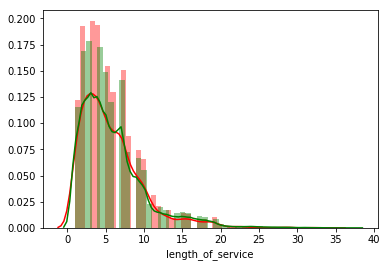

In [14]:
sns.distplot(data1[data1['is_promoted']==1]['length_of_service'], color='r')
sns.distplot(data1[data1['is_promoted']==0]['length_of_service'], color='g')

Based on the plot it can be said that age bins is not adding value. But our modelling is not bivariate modelling.So, it may happen that age might become important once it is seen with other variables.
From Domain standspoint- Age should be one of the factor which should be important while promoting people. Individually it doesn't make sense to promote people based on age, but with other varaible, it may be useful.

In [15]:
data1.columns
cols=['gender','no_of_trainings', 'age',
       'length_of_service', 'KPIs_met >80%', 'awards_won?',
       'avg_training_score']
cols_a=['gender','recruitment_channel', 'region', 'department','no_of_trainings', 'age',
       'length_of_service', 'KPIs_met >80%', 'awards_won?', 'mean_reg_dpt','new_avg_trng_score']
category_cols = ['gender','recruitment_channel', 'region', 'department']

In [16]:
data1.gender.unique()

array(['f', 'm'], dtype=object)

In [17]:
data2=data1
data2['gender']=data2['gender'].map({'m':1,'f':0})
#data2['recruitment_channel']=data2['recruitment_channel'].map({'sourcing':1,'other':0,'referred':2})
dum_recr=pd.get_dummies(data2['recruitment_channel'], prefix_sep='recr', drop_first=True)
#data2['department']=data2['department'].map({'Sales & Marketing':0, 'Operations':1, 'Technology':2, 'Analytics':3,
#       'R&D':4, 'Procurement':5, 'Finance':6, 'HR':7, 'Legal':8})
dum_dpt=pd.get_dummies(data2['department'], prefix_sep='dpt', drop_first=True)
data2=pd.concat([dum_dpt, dum_recr,data2], axis=1)


In [18]:
cols=cols+list(dum_recr.columns)+list(dum_dpt.columns)

In [19]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test=train_test_split(data2[cols], data2['is_promoted'], test_size=0.20, random_state=123)
x_train.head()

,gender,no_of_trainings,age,length_of_service,KPIs_met >80%,awards_won?,avg_training_score,referred,sourcing,Finance,HR,Legal,Operations,Procurement,R&D,Sales & Marketing,Technology
27494,1,2,24,2,0,0,49,0,0,0,0,0,0,0,0,1,0
492,1,1,25,1,0,0,65,0,1,0,0,0,1,0,0,0,0
5513,1,1,40,4,1,0,49,0,0,0,0,0,0,0,0,1,0
27964,0,1,28,5,0,0,85,0,0,0,0,0,0,0,0,0,0
14710,1,1,31,5,1,0,52,0,1,0,0,0,0,0,0,1,0


In [20]:
#automated feature selection using Standard Scikit Package. One of the most popular such algorithm is Random Forest
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import classification_report,matthews_corrcoef
clf=XGBClassifier().fit(x_train[cols],y_train)
#clf=CatBoostClassifier().fit(x_train[cols],y_train,plot=True,cat_features=category_cols,eval_set=(x_test,y_test))
print (classification_report(y_test,clf.predict(x_test[cols])))
print(matthews_corrcoef(y_test,clf.predict(x_test[cols])))

              precision    recall  f1-score   support

           0       0.94      1.00      0.97     10065
           1       0.96      0.29      0.45       897

    accuracy                           0.94     10962
   macro avg       0.95      0.64      0.71     10962
weighted avg       0.94      0.94      0.93     10962

0.5097410476339984


In [21]:
x_train,x_test,y_train,y_test=train_test_split(data1[cols_a], data1['is_promoted'], test_size=0.20, random_state=123)
clf=CatBoostClassifier().fit(x_train[cols_a],y_train,plot=True,cat_features=category_cols,eval_set=(x_test,y_test))
print (classification_report(y_test,clf.predict(x_test[cols_a])))
print(matthews_corrcoef(y_test,clf.predict(x_test[cols_a])))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.116052
0:	learn: 0.5150719	test: 0.5137810	best: 0.5137810 (0)	total: 159ms	remaining: 2m 39s
1:	learn: 0.4304156	test: 0.4282830	best: 0.4282830 (1)	total: 261ms	remaining: 2m 10s
2:	learn: 0.3728539	test: 0.3700043	best: 0.3700043 (2)	total: 331ms	remaining: 1m 50s
3:	learn: 0.3032781	test: 0.2998130	best: 0.2998130 (3)	total: 427ms	remaining: 1m 46s
4:	learn: 0.2753418	test: 0.2715070	best: 0.2715070 (4)	total: 521ms	remaining: 1m 43s
5:	learn: 0.2406212	test: 0.2364442	best: 0.2364442 (5)	total: 614ms	remaining: 1m 41s
6:	learn: 0.2287903	test: 0.2241144	best: 0.2241144 (6)	total: 703ms	remaining: 1m 39s
7:	learn: 0.2204018	test: 0.2153215	best: 0.2153215 (7)	total: 780ms	remaining: 1m 36s
8:	learn: 0.2007545	test: 0.1956236	best: 0.1956236 (8)	total: 879ms	remaining: 1m 36s
9:	learn: 0.1971026	test: 0.1917795	best: 0.1917795 (9)	total: 939ms	remaining: 1m 33s
10:	learn: 0.1940706	test: 0.1885822	best: 0.1885822 (10)	total: 1.03s	remaining: 1m 32s
11:	learn: 

The bar plot below on feature name and feature importance, produced many of the machine learning packages like Random Forest, LASSO Regression, CATBOOST, etc. helps in reducing the feature scope.

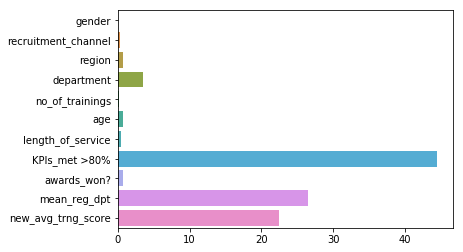

In [22]:
clf.feature_importances_
clf.feature_names_
sns.barplot(y=clf.feature_names_, x=clf.feature_importances_)
# Gender, awards_won, recruitment channel and no_of_traings recieved are few features marked as least important. 
#Let's analyse them, before we cross them off from our list
#gender- it points to fact that the dataset we have, belongs to a region where getting promoted is gender insensitive. More of just work culture.